# Projects in Information Systems Security Analytics

### Data Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('dataset.csv', index_col='URL')
df.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL,,,,,,,,,,,,,,,,,,,,
M0_109,16,7,iso-8859-1,nginx,263.0,NaN,NaN,10/10/2015 18:21,NaN,7,0,2,700,9,10,1153,832,9,2.0,1
B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,NaN,NaN,17,7,4,1230,17,19,1265,1230,17,0.0,0
B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0.0,0
B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
B0_403,17,6,UTF-8,NaN,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [3]:
df.shape

(1781, 20)

### Figuring the number of targets that we are dealing with

In [4]:
print(len(df[df['Type'] == 1]), "Targets")
print(len(df[df['Type'] == 0]), "Non Targets")

216 Targets
1565 Non Targets


In [5]:
df.dtypes

URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object

### Data Cleaning

In [6]:
print(df.isnull().sum())

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        7
SERVER                       176
CONTENT_LENGTH               812
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64


Given that we have only 1800 rows, instead of removing missing values, we perform several imputation techniques to retain the number of rows.

In [7]:
imputer = KNNImputer(n_neighbors=5)

# Impute missing values in the 'SERVER' column
df['CONTENT_LENGTH'] = imputer.fit_transform(df[['CONTENT_LENGTH']])

In [8]:
mode_value = df['SERVER'].mode().iloc[0]
df['SERVER'] = df['SERVER'].fillna(mode_value)

In [30]:
# Group by CHARSET and find the most frequent SERVER value for each CHARSET
char_server_mapping = df.groupby('CHARSET')['SERVER'].agg(lambda x: x.value_counts().index[0]).to_dict()
# Impute missing values in SERVER based on CHARSET
df['SERVER'] = df.apply(lambda row: char_server_mapping[row['CHARSET']] if pd.isnull(row['SERVER']) else row['SERVER'], axis=1)

In [10]:
mode_value = df['CHARSET'].mode().iloc[0]
df['CHARSET'] = df['CHARSET'].fillna(mode_value)

In [11]:
mean_value = df['DNS_QUERY_TIMES'].mean()
df['DNS_QUERY_TIMES'] = df['DNS_QUERY_TIMES'].fillna(mean_value)

In [12]:
print(df.isnull().sum())

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         0
CONTENT_LENGTH                 0
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                0
Type                           0
dtype: int64


### Visualizing Data as is

In [13]:
df['APP_BYTES'].min()

0

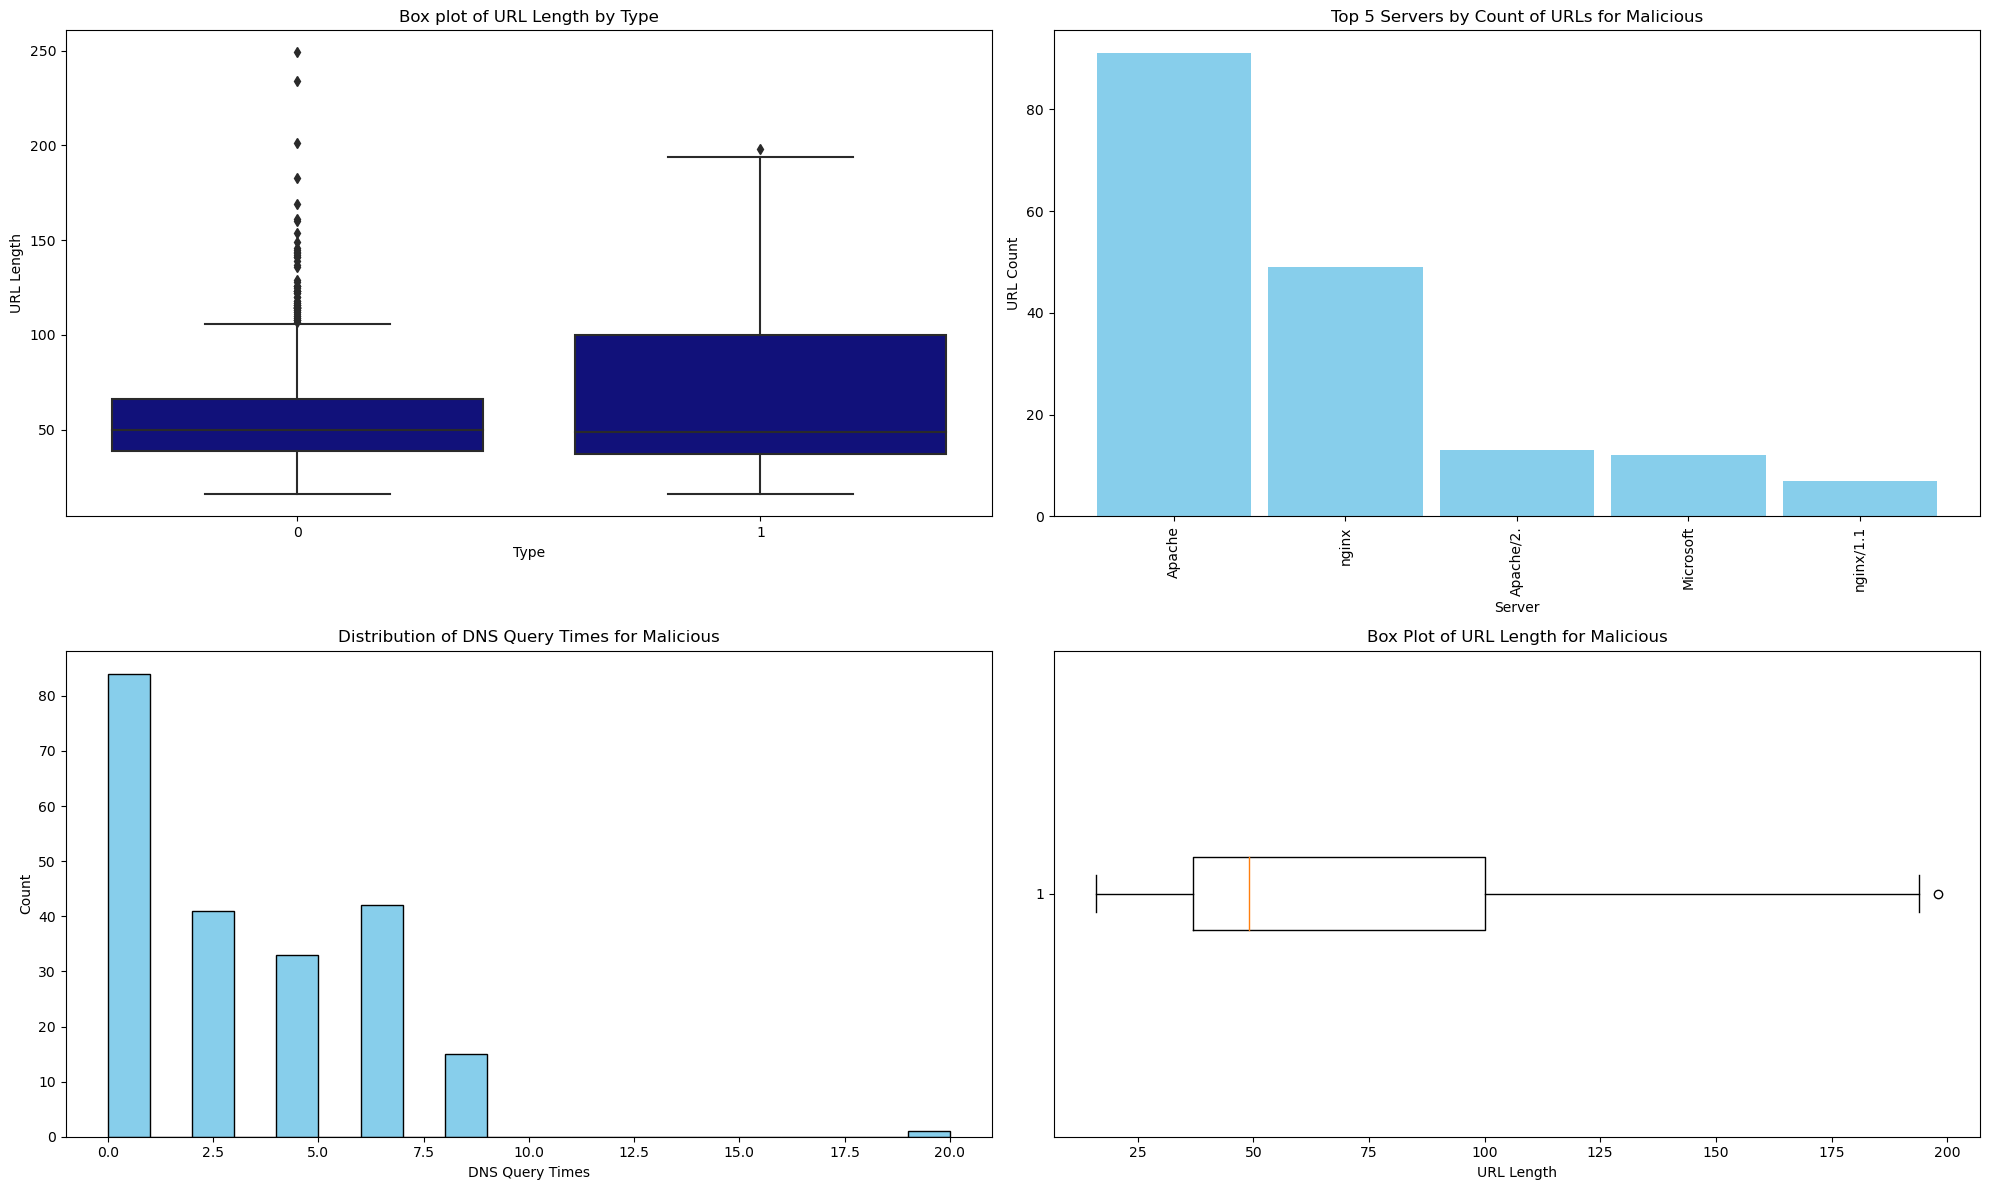

In [14]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Box plot of URL Length by Type
sns.boxplot(x='Type', y='URL_LENGTH', data=df, color='darkblue', ax=axs[0, 0])
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('URL Length')
axs[0, 0].set_title('Box plot of URL Length by Type')

# Bar plot of Top 5 Servers by Count of URLs (Type=1)
top_servers_type_1 = df[df['Type'] == 1]['SERVER'].value_counts().head(5)
ax = top_servers_type_1.plot(kind='bar', color='skyblue', width=0.9, ax=axs[0, 1])
ax.set_title('Top 5 Servers by Count of URLs for Malicious')
ax.set_xlabel('Server')
ax.set_ylabel('URL Count')

# Adjust x-axis tick labels
x_tick_labels = [label.get_text()[:9] for label in ax.get_xticklabels()]
ax.set_xticklabels(x_tick_labels)


# Histogram of DNS Query Times (Type=1)
axs[1, 0].hist(df[df['Type'] == 1]['DNS_QUERY_TIMES'], bins=20, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of DNS Query Times for Malicious')
axs[1, 0].set_xlabel('DNS Query Times')
axs[1, 0].set_ylabel('Count')

# Box plot of URL Length (Type=1)
axs[1, 1].boxplot(df[df['Type'] == 1]['URL_LENGTH'], vert=False)
axs[1, 1].set_title('Box Plot of URL Length for Malicious')
axs[1, 1].set_xlabel('URL Length')

# Adjust layout
plt.tight_layout()
plt.show()

### 1. How does the type of server correlate with the likelihood of a website being malicious?

In [15]:
from scipy.stats import chi2_contingency

# Contingency table of server types and website type
server_type_crosstab = pd.crosstab(df['SERVER'], df['Type'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(server_type_crosstab)

# Output the results
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 408.0774116023364
P-value: 3.237042060283905e-11


### 2. Is there a significant difference in DNS query times between malicious and benign websites?

In [16]:
from scipy.stats import shapiro, ttest_ind, levene

# Check for normality
stat, p_normal_malicious = shapiro(df[df['Type'] == 1]['DNS_QUERY_TIMES'])
stat, p_normal_benign = shapiro(df[df['Type'] == 0]['DNS_QUERY_TIMES'])

# Check for equal variances
stat, p_var = levene(df[df['Type'] == 1]['DNS_QUERY_TIMES'], df[df['Type'] == 0]['DNS_QUERY_TIMES'])

# t-test
t_stat, p_t_test = ttest_ind(df[df['Type'] == 1]['DNS_QUERY_TIMES'], df[df['Type'] == 0]['DNS_QUERY_TIMES'], equal_var=(p_var > 0.05))

# Results
print("Normality test p-value (malicious):", p_normal_malicious)
print("Normality test p-value (benign):", p_normal_benign)
print("Levene's test p-value for equal variances:", p_var)
print("T-test statistic:", t_stat)
print("P-value:", p_t_test)


Normality test p-value (malicious): 3.1181737066395465e-15
Normality test p-value (benign): 2.0318827732709848e-43
Levene's test p-value for equal variances: 0.39960551620062545
T-test statistic: 2.9066571486846655
P-value: 0.0036983424190695884


### 3. Do malicious websites typically have longer URL lengths compared to benign websites?

In [17]:
# Assuming previous steps for normality and variance checks are similar

# t-test
t_stat_url, p_t_test_url = ttest_ind(df[df['Type'] == 1]['URL_LENGTH'], df[df['Type'] == 0]['URL_LENGTH'], equal_var=(p_var > 0.05))

# Results
print("T-test statistic for URL length:", t_stat_url)
print("P-value:", p_t_test_url)


T-test statistic for URL length: 6.9289114506945975
P-value: 5.907189357077888e-12


### 4. How do the application bytes of malicious websites compare to those of benign websites?

Mean Application Bytes (Malicious): 1283.6157407407406
Mean Application Bytes (Benign): 3216.7955271565497


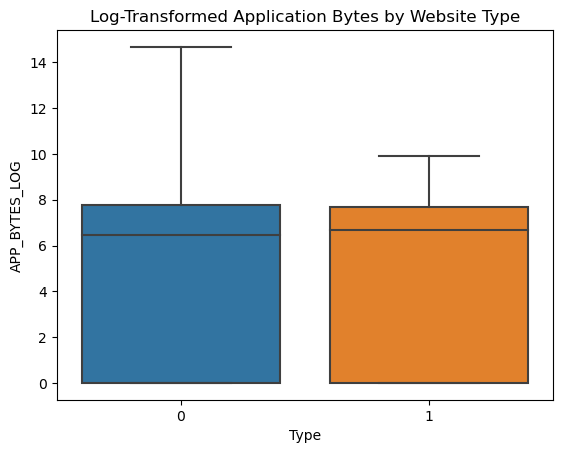

In [18]:
# Descriptive statistics
malicious_app_bytes_mean = df[df['Type'] == 1]['APP_BYTES'].mean()
benign_app_bytes_mean = df[df['Type'] == 0]['APP_BYTES'].mean()

print("Mean Application Bytes (Malicious):", malicious_app_bytes_mean)
print("Mean Application Bytes (Benign):", benign_app_bytes_mean)

# Log transformation (adding a small constant to avoid log(0))
df['APP_BYTES_LOG'] = np.log(df['APP_BYTES'] + 1)

# plot the log-transformed data
sns.boxplot(x='Type', y='APP_BYTES_LOG', data=df)
plt.title('Log-Transformed Application Bytes by Website Type')
plt.show()

### Can a predictive model accurately classify websites as malicious or benign based on available features?

#### Preprocess the Dataset

In [19]:
df_cleaned = df.drop(columns=['WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'])
df_cleaned.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,APP_BYTES_LOG
URL,,,,,,,,,,,,,,,,,
M0_109,16,7,iso-8859-1,nginx,263.0,7,0,2,700,9,10,1153,832,9,2.0,1,6.552508
B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,7.115582
B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,0,0,0,0,0,0,0,0,0,0.0,0,0.000000
B0_113,17,6,ISO-8859-1,nginx,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,8.246172
B0_403,17,6,UTF-8,Apache,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,8.361475


In [20]:
## Label Encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_cleaned['CHARSET'] = label_encoder.fit_transform(df_cleaned['CHARSET'])
df_cleaned['SERVER'] = label_encoder.fit_transform(df_cleaned['SERVER'])

df_cleaned.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,APP_BYTES_LOG
URL,,,,,,,,,,,,,,,,,
M0_109,16,7,3,199,263.0,7,0,2,700,9,10,1153,832,9,2.0,1,6.552508
B0_2314,16,6,2,61,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,7.115582
B0_911,16,6,4,115,324.0,0,0,0,0,0,0,0,0,0,0.0,0,0.000000
B0_113,17,6,1,199,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,8.246172
B0_403,17,6,2,7,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,8.361475


In [21]:
    df_cleaned.dtypes

URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                        int32
SERVER                         int32
CONTENT_LENGTH               float64
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
APP_BYTES_LOG                float64
dtype: object

#### Split the data

In [22]:
X = df_cleaned.drop('Type', axis=1)  # Features
y = df_cleaned['Type']               # Target

# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#### Standardizing the Feature Values

In [23]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Initialize the RandomForestClassifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the scaled training data.
rf_classifier.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

#### Evaluate the Model's Performance

In [25]:
# Predict the target for the testing set.
y_pred = rf_classifier.predict(X_test_scaled)

# Classification report and confusion matrix to evaluate the model.
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       462
           1       0.96      0.71      0.82        73

    accuracy                           0.96       535
   macro avg       0.96      0.85      0.90       535
weighted avg       0.96      0.96      0.95       535

[[460   2]
 [ 21  52]]


#### Interpret the results

In [26]:
# Feature importances.
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                           importance
SOURCE_APP_BYTES             0.100700
DIST_REMOTE_TCP_PORT         0.100395
REMOTE_APP_PACKETS           0.092663
NUMBER_SPECIAL_CHARACTERS    0.087357
CONTENT_LENGTH               0.075600
APP_BYTES                    0.075464
URL_LENGTH                   0.063896
REMOTE_APP_BYTES             0.063370
APP_BYTES_LOG                0.055705
SERVER                       0.054801
APP_PACKETS                  0.043186
SOURCE_APP_PACKETS           0.043026
TCP_CONVERSATION_EXCHANGE    0.042652
CHARSET                      0.039629
DNS_QUERY_TIMES              0.032071
REMOTE_IPS                   0.029486


In [27]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


X = df_cleaned.drop('Type', axis=1)  # Features
y = df_cleaned['Type']               # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base learners
model1 = LogisticRegression(random_state=42)
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model3 = SVC(probability=True, random_state=42)

# Create ensemble model with soft voting
ensemble = VotingClassifier(estimators=[
    ('lr', model1), ('rf', model2), ('svm', model3)
], voting='soft')

# Train the ensemble model
ensemble.fit(X_train_scaled, y_train)




VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [28]:
# Evaluate the ensemble model
y_pred = ensemble.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9364485981308411
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       462
           1       1.00      0.53      0.70        73

    accuracy                           0.94       535
   macro avg       0.97      0.77      0.83       535
weighted avg       0.94      0.94      0.93       535

Confusion Matrix:
 [[462   0]
 [ 34  39]]
